# Feature Engineering and Model Building

In [1]:
# importing all the required libraries, all the libraries that will be used in this notebookabs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style='whitegrid', palette='tab10')
import warnings 
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_curve, recall_score
from sklearn.multiclass import OneVsRestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [2]:
# importing the available data files, reading the dimensions and then merging into 1 main dataframe for our use.

csv_files_list = ["Normal.csv", "Type_H.csv", "Type_S.csv"]  # list of the .csv files we have
df_list = []

for file in csv_files_list:   # reading the shape of each file
    df = pd.read_csv("D:/art_intel/03_supervised_learning/Project/healthcare_project_data/{}".format(file)) 
    print("Shape of '{0}' dataframe: {1}".format(file, df.shape)) 
    df_list.append(df)
        
main_df = pd.concat(df_list)    # merging all the dataframes into one
print("\nshape of the final dataframe after merging the above {0} dataframes: {1}".format(len(df_list), main_df.shape))

Shape of 'Normal.csv' dataframe: (100, 7)
Shape of 'Type_H.csv' dataframe: (60, 7)
Shape of 'Type_S.csv' dataframe: (150, 7)

shape of the final dataframe after merging the above 3 dataframes: (310, 7)


### Data Preprocessing

In [3]:
# Fixing the labelling of the Class variable
main_df['Class'] = main_df['Class'].replace("Nrmal", "Normal").replace("type_h", "Type_H").replace("tp_s", "Type_S")
main_df['Class'].value_counts()

Type_S    150
Normal    100
Type_H     60
Name: Class, dtype: int64

In [4]:
# checking how many rows will be affected if we delete the outlier
len(main_df[main_df['S_Degree']>400])

1

In [5]:
# only 1 record where S_Degree value is >400, so removing the outlier
main_df = main_df[main_df['S_Degree']<400]
main_df.shape

(309, 7)

In [6]:
# Separating predictors from target variable
x_vars = main_df.iloc[:, :-1]   # predictor variables
y_var = main_df['Class']   # target variable

In [7]:
# Scaling the inputs, because we are using KNN-classifier which is distance based 
# MinMax scaler
scaler = MinMaxScaler()
scaled_x = scaler.fit_transform(x_vars)
scaled_x = pd.DataFrame(scaled_x, columns=main_df.iloc[:,:-1].columns)
print("Predictor variables after MinMax scaling:\n")
scaled_x

Predictor variables after MinMax scaling:



,P_incidence,P_tilt,L_angle,S_slope,P_radius,S_Degree
0,0.134324,0.420085,0.188942,0.123236,0.618897,0.119170
1,0.312760,0.455882,0.336501,0.340511,0.599688,0.081720
2,0.197991,0.276858,0.294446,0.332440,0.635973,0.100445
3,0.240998,0.428799,0.304271,0.263838,0.633388,0.063495
4,0.212550,0.307480,0.255748,0.326784,0.646271,0.047989
...,...,...,...,...,...,...
304,0.586582,0.723338,0.636299,0.494544,0.596967,0.696758
305,0.753639,0.948527,0.402712,0.536171,0.286071,0.552783
306,0.521179,0.453297,0.555135,0.631768,0.627209,0.528411
307,0.668841,0.480838,0.714343,0.813327,0.546974,0.549326


In [8]:
# converting the classes of target variable to numeric values
y_labl = LabelEncoder().fit_transform(y_var)

In [9]:
# finding out the value count of the y_labl nparray
val_dict = {}
for i in np.unique(y_labl):
    val_dict[i] = 0
    clist = []
    for x in y_labl:
        if x == i:
            clist.append(x)
    val_dict[i] = len(clist)
print("Value count of the target variable after label encoding:",val_dict)

Value count of the target variable after label encoding: {0: 100, 1: 60, 2: 149}


- The target variable classes are slightly imbalanced

In [10]:
# splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(scaled_x, y_labl, test_size=0.25, random_state=24)

### 5. Model training, testing and tuning

Training accuracy score: 86.5801%
Test accuracy score: 87.1795%



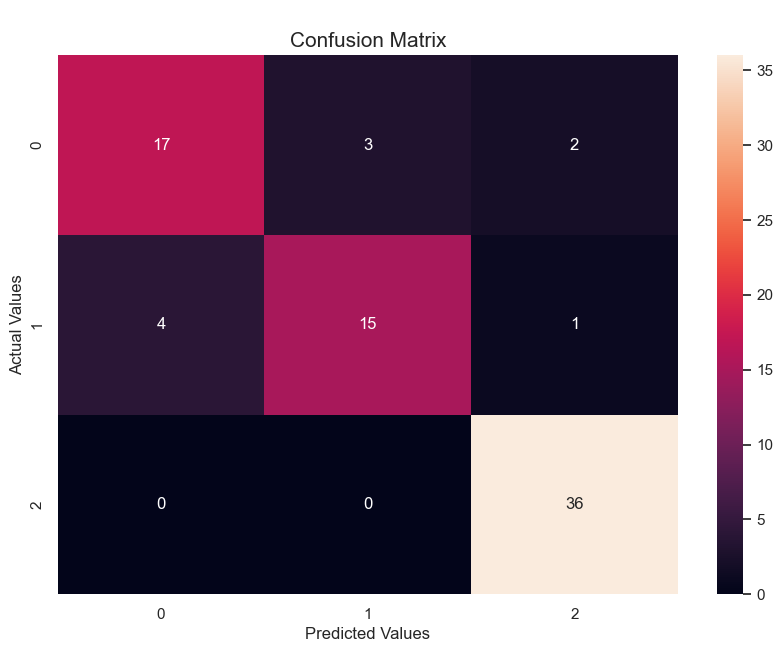




Classification Report: 
              precision    recall  f1-score   support

           0       0.81      0.77      0.79        22
           1       0.83      0.75      0.79        20
           2       0.92      1.00      0.96        36

    accuracy                           0.87        78
   macro avg       0.86      0.84      0.85        78
weighted avg       0.87      0.87      0.87        78





In [28]:
#================ base model ====================#
# fitting the knn algorithm, checking the score of train and test, and generating the classification matrix and report
knn = KNeighborsClassifier()
knn_model = knn.fit(X_train, y_train)
train_pred = knn_model.predict(X_train)
y_pred = knn_model.predict(X_test)   # predicting the labels 

# training accuracy
train_result = accuracy_score(train_pred, y_train)    
print("Training accuracy score: {:.4f}%".format(train_result*100))
# test accuracy
test_result = accuracy_score(y_test, y_pred)          
print("Test accuracy score: {:.4f}%\n".format(test_result*100))

# confusion matrix
c_matrix = confusion_matrix(y_test, y_pred)        
cmatrix_df = pd.DataFrame(c_matrix, index = [0,1,2], columns = [0,1,2])
# Plotting the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cmatrix_df, annot=True)
plt.title('\nConfusion Matrix', fontsize=15)
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

print("\n\n")
cr_result = classification_report(y_test, y_pred)
print("Classification Report: \n{}\n\n".format(cr_result))


In [29]:
knn_model.get_params() # default hyper-parameters used by the algorithm 

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

##### Points about the above measures -
1. Train and test accuracy scores have a small difference between their scores, so low model overfitting is there.
2. Interpreting the confusion matrix for multiclass classifier:
     - Diagonal axis represents the **True Positive** values of the classes.
         - 0 = 17
         - 1 = 15
         - 2 = 36
     - If the actual value is 0 and model predicted some other class, that is the **False Negative** value of the class.
         - 0 = 5 (3+2)
         - 1 = 5 (4+1)
         - 2 = 0
     - On the other hand, **False Positive** value of the class are the exact opposite of false negatives.
         - 0 = 4 (4+0)
         - 1 = 3 (3+0)
         - 2 = 3 (2+1)
     - The **True Negative** values of a class will be the sum of values of all other rows and columns
         - 0 = 42 (5+1+0+36)
         - 1 = 55 (17+2+0+36)
         - 2 = 39 (17+3+4+15)
         
3. Since we are predicting the type of condition a patient belongs to, it will be better to reduce **False Negatives** as much as possible. This is because, if the model miss-classifies class-1 (Type_H) or class-2 (Type_S) with class-0 (Normal), the patient with abnormal condition will be set to Normal case and it will be a bigger error from the model than mis-classifying a Normal case with Type_H or Type_S condition.
4. For our use case, the **recall** score needs to be reduced to as low as possibe (zero) without the data getting overfitted.

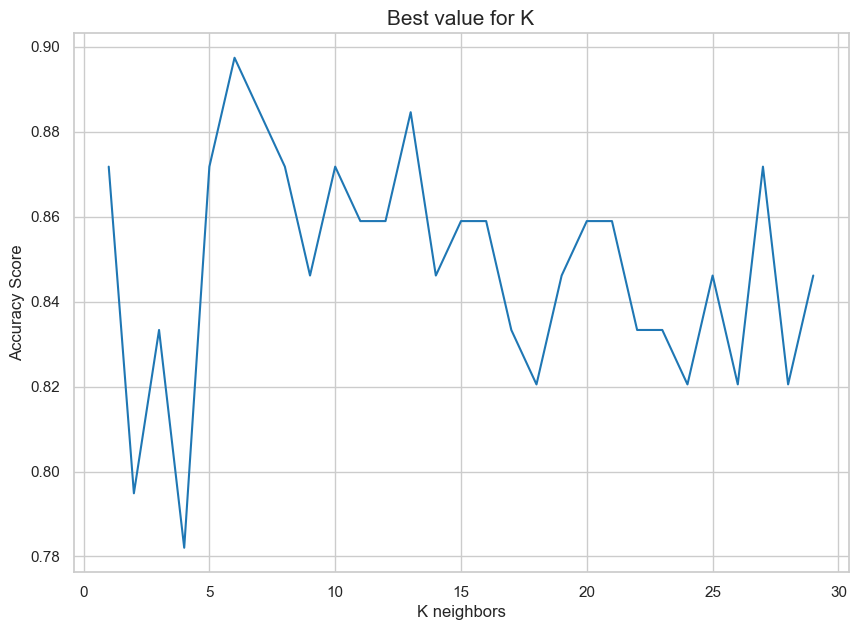

In [34]:
# finding the best K-value for the model
scores = []
for k in range(1,30):
    knn = KNeighborsClassifier(n_neighbors = k)
    model = knn.fit(X_train, y_train)
    mscore = model.score(X_test, y_test) 
    scores.append(mscore)

plt.figure(figsize=(10,7))
plt.plot(range(1,30), scores)
plt.xlabel("K neighbors")
plt.ylabel("Accuracy Score")
plt.title("Best value for K", fontsize = 15)
plt.show()

Training accuracy score: 86.58%
Test accuracy score: 84.62%



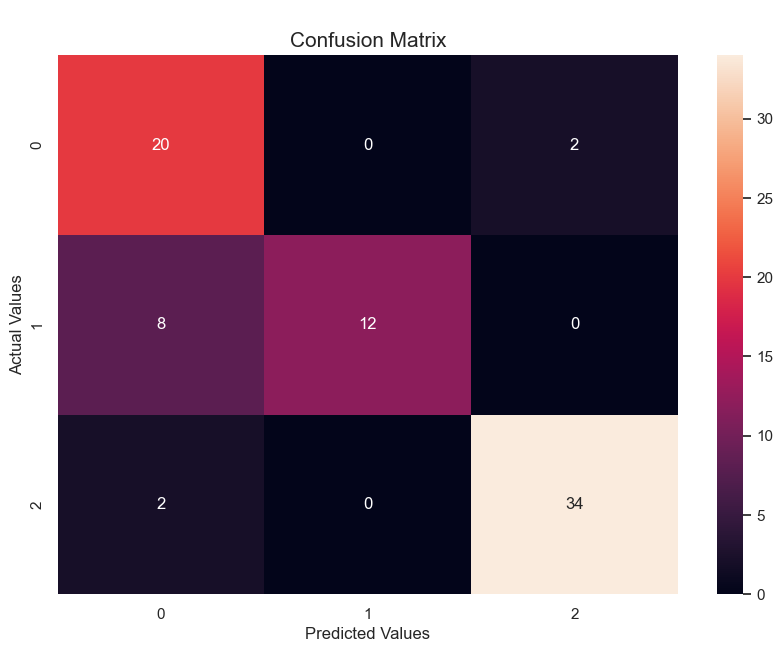




Classification Report: 
              precision    recall  f1-score   support

           0       0.67      0.91      0.77        22
           1       1.00      0.60      0.75        20
           2       0.94      0.94      0.94        36

    accuracy                           0.85        78
   macro avg       0.87      0.82      0.82        78
weighted avg       0.88      0.85      0.85        78





In [39]:
#=============== Model after finding out the best k value ======================#
# fitting the knn algorithm, checking the score of train and test, and generating the classification matrix and report
# setting the n_neighbor value = 10, as found out from the above graph
knn = KNeighborsClassifier(n_neighbors = 5)
knn_model = knn.fit(X_train, y_train)
train_pred = knn_model.predict(X_train)
y_pred = model.predict(X_test)   # predicting the labels 

# training accuracy
train_result = accuracy_score(train_pred, y_train)    
print("Training accuracy score: {:.2f}%".format(train_result*100))
# test accuracy
test_result = accuracy_score(y_test, y_pred)          
print("Test accuracy score: {:.2f}%\n".format(test_result*100))

# confusion matrix
c_matrix = confusion_matrix(y_test, y_pred)        
cmatrix_df = pd.DataFrame(c_matrix, index = [0,1,2], columns = [0,1,2])
# rPlotting the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cmatrix_df, annot=True)
plt.title('\nConfusion Matrix', fontsize=15)
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

print("\n\n")
cr_result = classification_report(y_test, y_pred)
print("Classification Report: \n{}\n\n".format(cr_result))


In [40]:
# using the Statrified K-fold Cross-validation 
# since we have imbalanced target classes
n_folds = 10  # 10-fold CV

def score(model, xdata, y_data):
    skf = StratifiedKFold(n_folds, shuffle = True, random_state = 24).get_n_splits(xdata)
    accuracy = cross_val_score(model, xdata, y_data, scoring = "accuracy", cv = skf)
    precision = accuracy = cross_val_score(model, xdata, y_data, scoring = "precision_macro", cv = skf)
    recall = accuracy = cross_val_score(model, xdata, y_data, scoring = "recall_macro", cv = skf)
    return print("Accuracy Score: {:.2f}% \nPrecision Score: {:.2f}% \nRecall Score: {:.2f}%".format(accuracy.mean()*100, precision.mean()*100, recall.mean()*100))

# calling the above defined function
cv_score = score(knn, scaled_x, y_labl)
cv_score

Accuracy Score: 76.22% 
Precision Score: 78.37% 
Recall Score: 76.22%


In [ ]:
# trying to find out the best threshold for the recall
# need to set the threshold value <0.5, in order to bring its value up
# using the precision_recall_curve to find the threshold value

n_classes = len(set(y_labl))
y_lbin = label_binarize(y_labl, classes=list(range(n_classes)))
X_train, X_test, y_train, y_test = train_test_split(scaled_x, y_lbin, random_state = 24)

knn_clf = OneVsRestClassifier(KNeighborsClassifier(n_neighbors = 10))
proto_model = knn_clf.fit(X_train, y_train)
y_score = knn_clf.predict_proba(X_test)

# plotting the precision vs recall curve
precision = {}
recall = {}
thold_list = []
plt.figure(figsize=(10,7))
for i in range(n_classes):
    precision[i], recall[i], thresholds = precision_recall_curve(y_test[:, i], y_score[:, i])
    #thold_list.append(thresholds)
    thold_list += [t for t in thresholds]
    plt.plot(recall[i], precision[i], lw=2, label='Class {}'.format(i))
    
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("Precision vs. Recall curve", fontsize=15)
plt.show()

# creating a range of threshold values between 0-1, with a step rate of 0.001
thold_range = np.arange(0, 1, 0.001)

# making a function to filter out the threshold values giving max recall score
def to_labels(pos_probs, threshold):   
    return (pos_probs >= threshold).astype('int')

# recall scores of the particular threshold range as defined
scores = [recall_score(y_test, to_labels(y_score, t), average="weighted") for t in thold_range] 
ix = np.argmax(scores)  # selecting the best score from the list
print("\n\n*************************\n")
print("Best Recall-Score = {:.3f} at Threshold = {:.3f}".format(scores[ix], thold_range[ix]))

In [41]:
final_knn = KNeighborsClassifier(n_neighbors = 5)
final_knn_model = final_knn.fit(X_train, y_train)
# train_pred = knn_model.predict(X_train)
y_pred = model.predict(X_test)   # predicting the labels 

test_result = accuracy_score(y_test, y_pred)          
print("Test accuracy score: {:.2f}%\n".format(test_result*100))


Test accuracy score: 84.62%



### 6. Conclusion
1. About the final model:
    - model gave a **92.3%** accuracy, with n_neighbors = 10, and using train_test_split
        - after adjusting with the best n_neighbors parameter = **10**
        - this model seemed to start overfitting the data a little, by this point
        - with average recall being **90.3%**, this classifier was still predicting some Type_H False Negatives
        - however this was predicting Type_S conditions perfectly
    - used the above model with **Stratified K-fold CV**
        - k = **10** splits
        - got around **78%** recall score, same as accuracy score
    - to improve the recall score, played around with the precision_recall_curve to fetch the threshold values
        - got the best Recall-score = 1.000 
        - for the threshold value = 0.000
        - this might be overfitting the data as well
        - for which it will be better to use the cross validation for this as well ahead in the modelling
    - So, currently the best performing model = **cv_score, Stratified K-fold CV**
        - because it is having a lower chance with respect to overfitting
        - Even though we are getting a pretty good accuracy score and Recall score at n_neighbors = 10, using train_test_split
        - more probe is required for this model to be used, and to be sure that it is not overfitting
2. Going forward from here, much more improvements can be done. By tuning the model better, we can produce a good recall score.

3. Will need to validate the currently acquired Recall-Score and Threshold value, by using the kfold CV. 

4. Need to find the optimal Threshold value for our model, to better the Recall-Score 

5. Also, a better clarity regarding the nature of variables would be much better. Since in this case we did not know the details about the condition, how are the independent variables associated with target variables to be precise (although EDA somewhat explained a basic relationship between them). The data should be having a more detailed description about how it got collected, what are the units of the variables, length of the data should be more as larger the size of the data better it will be for our algorithm to find the hidden patterns in the data. 

----